## IMDb

At Fast.ai we have introduced a new module called fastai.text which replaces the torchtext library that was used in our 2018 dl1 course. The fastai.text module also supersedes the fastai.nlp library but retains many of the key functions.

In [1]:
from fastai.text import *
from fastai.imports import *
import html

The Fastai.text module introduces several custom tokens.

We need to download the IMDB large movie reviews from this site: http://ai.stanford.edu/~amaas/data/sentiment/
Direct link : [Link](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and untar it into the PATH location. We use pathlib which makes directory traveral a breeze.

In [2]:
DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)
#! curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
#! tar -xzfv aclImdb_v1.tar.gz -C {DATA_PATH}

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

## Standardize format

In [4]:
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

The imdb dataset has 3 classes. positive, negative and unsupervised(sentiment is unknown). 
There are 75k training reviews(12.5k pos, 12.5k neg, 50k unsup)
There are 25k validation reviews(12.5k pos, 12.5k neg & no unsup)

Refer to the README file in the imdb corpus for further information about the dataset.

In [95]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [96]:
len(trn_texts),len(val_texts)

(75000, 25000)

In [102]:
trn_labels[0:12]

array([2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2])

Now let's cut the data down by a factor of 10 (use only 10% of the data) so we can run it in a reasonable period of time on a cpu.

In [214]:
trn_texts = trn_texts[0:7500]
val_texts = val_texts[0:2500]

trn_labels = trn_labels[0:7500]
val_labels = val_labels[0:2500]

len(trn_texts),len(val_texts),len(trn_labels),len(val_labels)

(7500, 1000, 7500, 1000)

In [104]:
trn_labels

array([2, 0, 1, ..., 2, 0, 2])

In [ ]:
trn_texts = trn_texts[0:7500]
val_texts = val_texts[0:2500]

trn_labels = trn_labels[0:7500]
val_labels = val_labels[0:2500]

len(trn_texts),len(val_texts),len(trn_labels),len(val_labels)

In [105]:
col_names = ['labels','text']

We use a random permutation np array to shuffle the text reviews.

In [106]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

trn_idx

array([ 970, 6279, 1859, ..., 5390,  860, 7270])

In [107]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [108]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets. In the case of IMDB, there is only one text column.

In [109]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

We start by creating the data for the Language Model(LM). The LM's goal is to learn the structure of the english language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.

The LM can benefit from all the textual data and there is no need to exclude the unsup/unclassified movie reviews.

We first concat all the train(pos/neg/unsup = **75k**) and test(pos/neg=**25k**) reviews into a big chunk of **100k** reviews. And then we use sklearn splitter to divide up the 100k texts into 90% training and 10% validation sets.

In [110]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [111]:
len(trn_texts), len(val_texts)

(9000, 1000)

In [112]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [27]:
!conda install spacy -y

Solving environment: done

## Package Plan ##

  environment location: /anaconda3/envs/fastai-cpu

  added / updated specs: 
    - spacy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-base-1.15.2          |   py36h8a80b8c_1         4.1 MB
    spacy-2.0.12               |   py36h6440ff4_0        45.2 MB
    mkl_fft-1.0.6              |   py36hb8a8100_0         139 KB
    numpy-1.15.2               |   py36h6a91979_1          48 KB
    mkl_random-1.0.1           |   py36h5d10147_1         349 KB
    scipy-1.1.0                |   py36h28f7352_1        15.4 MB
    ------------------------------------------------------------
                                           Total:        65.3 MB

The following NEW packages will be INSTALLED:

    libcxx:          4.0.1-h579ed51_0                                
    libcxxabi:       4.0.1-hebd6815_0                                
    mkl_f

In [5]:
!python -m spacy download en

    100% |████████████████████████████████| 37.4MB 58.0MB/s ta 0:00:01    40% |████████████▉                   | 15.0MB 15.3MB/s eta 0:00:02    51% |████████████████▍               | 19.1MB 25.1MB/s eta 0:00:01
  Running setup.py install for en-core-web-sm ... done

    Linking successful
    /anaconda3/envs/fastai-cpu-s/lib/python3.6/site-packages/en_core_web_sm
    -->
    /anaconda3/envs/fastai-cpu-s/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [7]:
import spacy 
spacy.load('en')

In [113]:
chunksize=24000

In [114]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [13]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [116]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [117]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [118]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [119]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [120]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

**Here is where we can load the pre-processed language model tokens from the IMDB data.**

In [5]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [14]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 122794),
 ('.', 99634),
 (',', 98883),
 ('and', 59313),
 ('a', 58544),
 ('of', 53136),
 ('to', 49353),
 ('is', 39785),
 ('it', 34539),
 ('in', 34416),
 ('i', 31570),
 ('this', 27182),
 ('that', 26434),
 ('"', 24131),
 ("'s", 22591),
 ('-', 18511),
 ('was', 18187),
 ('\n\n', 17893),
 ('as', 16687),
 ('movie', 16022),
 ('with', 15892),
 ('for', 15825),
 ('but', 15158),
 ('film', 14730),
 (')', 12434)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [123]:
max_vocab = 60000
min_freq = 2

In [124]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [125]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

24602

In [12]:
tok_val[0]

['\n',
 'xbos',
 'xfld',
 '1',
 'i',
 'will',
 'not',
 'say',
 'much',
 'about',
 'this',
 'film',
 ',',
 'because',
 'there',
 'is',
 'not',
 'much',
 'to',
 'say',
 ',',
 'because',
 'there',
 'is',
 'not',
 'much',
 'there',
 'to',
 'talk',
 'about',
 '.',
 'the',
 'only',
 'good',
 'thing',
 'about',
 'this',
 'movie',
 'is',
 'that',
 'our',
 'favorite',
 'characters',
 'from',
 '"',
 'atlantis',
 ':',
 'the',
 'lost',
 'empire',
 '"',
 'are',
 'back',
 '.',
 'several',
 'of',
 'the',
 'bad',
 'things',
 'about',
 'this',
 'movie',
 'are',
 'that',
 'it',
 'has',
 'horrible',
 'characters',
 ',',
 'it',
 'has',
 'horrible',
 'comedy',
 ',',
 'horrible',
 'animation',
 ',',
 'and',
 'james',
 'arnold',
 'taylor',
 'trying',
 'to',
 'copy',
 'the',
 'wonderful',
 ',',
 'one',
 'and',
 'only',
 'michael',
 'j.',
 'fox',
 'as',
 'milo',
 'james',
 'thatch',
 '.',
 'the',
 'reasons',
 'for',
 'my',
 'criticisms',
 'are',
 'that',
 'all',
 'the',
 'characters',
 'are',
 'changed',
 'int

In [126]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [127]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

Here is where we can load the pre-processed int version of the IMBA data, including the vocab int-to-str converter.

In [16]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [9]:
val_lm[0]

[40,
 41,
 42,
 39,
 12,
 107,
 31,
 154,
 92,
 56,
 13,
 25,
 4,
 101,
 53,
 9,
 31,
 92,
 8,
 154,
 4,
 101,
 53,
 9,
 31,
 92,
 53,
 8,
 715,
 56,
 3,
 2,
 80,
 66,
 172,
 56,
 13,
 21,
 9,
 14,
 279,
 564,
 122,
 50,
 15,
 4596,
 103,
 2,
 441,
 4175,
 15,
 34,
 160,
 3,
 453,
 7,
 2,
 95,
 199,
 56,
 13,
 21,
 34,
 14,
 10,
 59,
 494,
 122,
 4,
 10,
 59,
 494,
 223,
 4,
 494,
 726,
 4,
 5,
 589,
 3977,
 2404,
 281,
 8,
 941,
 2,
 419,
 4,
 38,
 5,
 80,
 594,
 3280,
 1649,
 20,
 4602,
 589,
 22975,
 3,
 2,
 959,
 23,
 76,
 8910,
 34,
 14,
 43,
 2,
 122,
 34,
 1213,
 100,
 156,
 14,
 45,
 130,
 85,
 4,
 5,
 130,
 149,
 37,
 4,
 726,
 14,
 59,
 93,
 0,
 8,
 2,
 5317,
 2951,
 720,
 4,
 5,
 454,
 4,
 148,
 71,
 1651,
 47,
 86,
 419,
 581,
 17,
 139,
 184,
 23,
 11655,
 17,
 7651,
 0,
 11,
 15,
 5949,
 1720,
 15,
 203,
 8,
 941,
 594,
 3280,
 1649,
 65,
 12,
 615,
 8,
 36,
 48,
 1499,
 8,
 13,
 3,
 101,
 45,
 34,
 2,
 187,
 413,
 47,
 214,
 33,
 82,
 8,
 941,
 1556,
 1641,
 50,
 0,
 11,

In [7]:
vs=len(itos)
vs,len(trn_lm)

(24602, 9000)

## wikitext103 conversion

We are now going to build an english language model for the IMDB corpus. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the IMDB LM. 

In [ ]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

In [8]:
em_sz,nh,nl = 400,1150,3

Note that the 'models' directory should be in 'aclimbd'.

In [9]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [10]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [12]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

NameError: name 'to_np' is not defined

In [134]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

**I don't really understand what's going on here...**

In [135]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [136]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the IMDB LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [14]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [17]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

AttributeError: 'numpy.ndarray' object has no attribute 'ids'

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

**Haha sounds so ominous.**

In [139]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [140]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [141]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [142]:
lr=1e-3
lrs = lr

In [143]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                         
    0      4.872352   4.650989   0.240532  


[array([4.65099]), 0.240531840233819]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [144]:
learner.save('lm_last_ft')

**Here is where we can load the trained model.**

In [145]:
learner.load('lm_last_ft')

In [146]:
learner.unfreeze()

In [147]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                         
    0      4.74435    4.596504   0.233329  


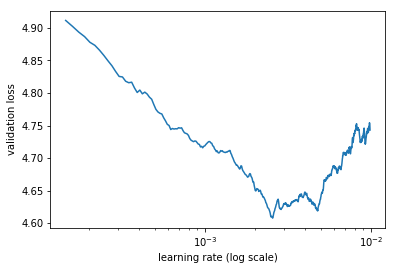

In [148]:
learner.sched.plot()

In [150]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)

epoch      trn_loss   val_loss   accuracy                       
    0      4.475427   4.257903   0.266149  
    1      4.279309   4.181427   0.273132                       
    2      4.125164   4.153999   0.276105                       
    3      4.035705   4.141493   0.278003                       
    4      3.955679   4.140333   0.27888                        


[array([4.14033]), 0.27888015710003544]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [151]:
learner.save('lm1')

In [152]:
learner.save_encoder('lm1_enc')

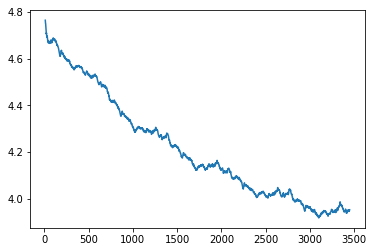

In [153]:
learner.sched.plot_loss()

In [186]:
s = "The movie was"
ss = s.lower().split()
si = [stoi[w] for w in ss]
print(ss)
print(si)

['the', 'movie', 'was']
[2, 21, 18]


In [187]:
m=learner.model
t=torch.autograd.Variable(torch.LongTensor(np.array([si])))
print(t)

Variable containing:
  2  21  18
[torch.LongTensor of size 1x3]



In [219]:
m[0].bs=1  # Set batch size to 1
m.eval()  # Turn off dropout
m.reset()  # Reset hidden state
res,*_ = m(t)  # Get predictions from model
m[0].bs=bs  # Put the batch size back to what it was

In [220]:
nexts = torch.topk(res[-1], 10)[1]
#nexts = torch.multinomial(res[-1].exp(), 10)
#nexts = res[-1].topk(20)[1]

for i in nexts.data.numpy():
    print(itos[i])

a
the
not
an
one
also
n't
in
made
just


In [221]:
print(s,"\n")
for i in range(50):
    n = res[-1].topk(2)[1]
    n = torch.multinomial(res[-1].exp(), 2)
    n = n[1] if n.data[0]==0 else n[0]
    print(itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

The movie was 

the book 's theme of a major evils that bloody jungle eggs become the result of condemns oppression . this movie is rarely seen on the t_up dvd with many of its more commendable actors playing the ' lead they 've been in . it 's a disappointment since the ...


## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [ ]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [ ]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [ ]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [ ]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [ ]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

In [ ]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [ ]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [ ]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [ ]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [ ]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [ ]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [ ]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [ ]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [ ]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [ ]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [ ]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [ ]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [ ]:
learn.freeze_to(-1)

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot()

A Jupyter Widget

 80%|███████▉  | 625/782 [01:39<00:24,  6.31it/s, loss=1.28] 

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.365457   0.185553   0.928719  



[0.18555279, 0.9287188090884525]

In [ ]:
learn.save('clas_0')

In [ ]:
learn.load('clas_0')

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.340473   0.17319    0.933125  



[0.17319041, 0.9331253991245995]

In [ ]:
learn.save('clas_1')

In [ ]:
learn.load('clas_1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.337347   0.186812   0.930782  
    1      0.284065   0.318038   0.932062                      
    2      0.246721   0.156018   0.941747                      
    3      0.252745   0.157223   0.944106                      
    4      0.24023    0.159444   0.945393                      
    5      0.210046   0.202856   0.942858                      
    6      0.212139   0.149009   0.943746                      
    7      0.21163    0.186739   0.946553                      
    8      0.186233   0.1508     0.945218                      
    9      0.176225   0.150472   0.947985                      
    10     0.198024   0.146215   0.948345                      
    11     0.20324    0.189206   0.948145                      
    12     0.165159   0.151402   0.947745                      
    13     0.165997   0.146615   0.947905                      



[0.14661488, 0.9479046703071374]

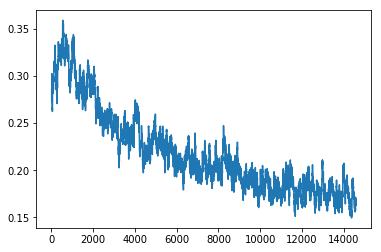

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('clas_2')

The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).

## Fin

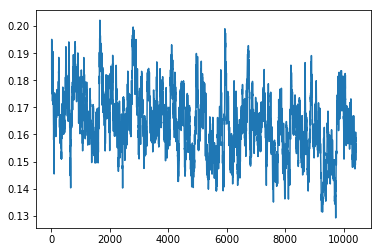

In [ ]:
learn.sched.plot_loss()